## This notebook implements differential gene expression using scanpy over a reference set

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gseapy
import os 

In [2]:
os.chdir('..')

### Load Sampled Reference

In [3]:
reference = sc.read_h5ad('data/full_fetal_brain/h5ad/down_fullref.h5ad')
reference = reference[reference.obs["CellClass"].isin(["Radial glia", "Oligo", "Glioblast"])]

### Preprocessing 

In [4]:
genes_to_filter = reference.var_names.str.startswith(('LINC', 'MI', 'SOX2-OT','RP'))
reference = reference[:, ~genes_to_filter]
sc.pp.filter_cells(reference, min_genes=500)
sc.pp.filter_genes(reference, min_cells=3)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


In [5]:
reference.layers["counts"] = reference.X.copy()

In [6]:
sc.pp.normalize_total(reference, target_sum=1e6)
sc.pp.log1p(reference)

#### Differential Gene Expression one vs others 

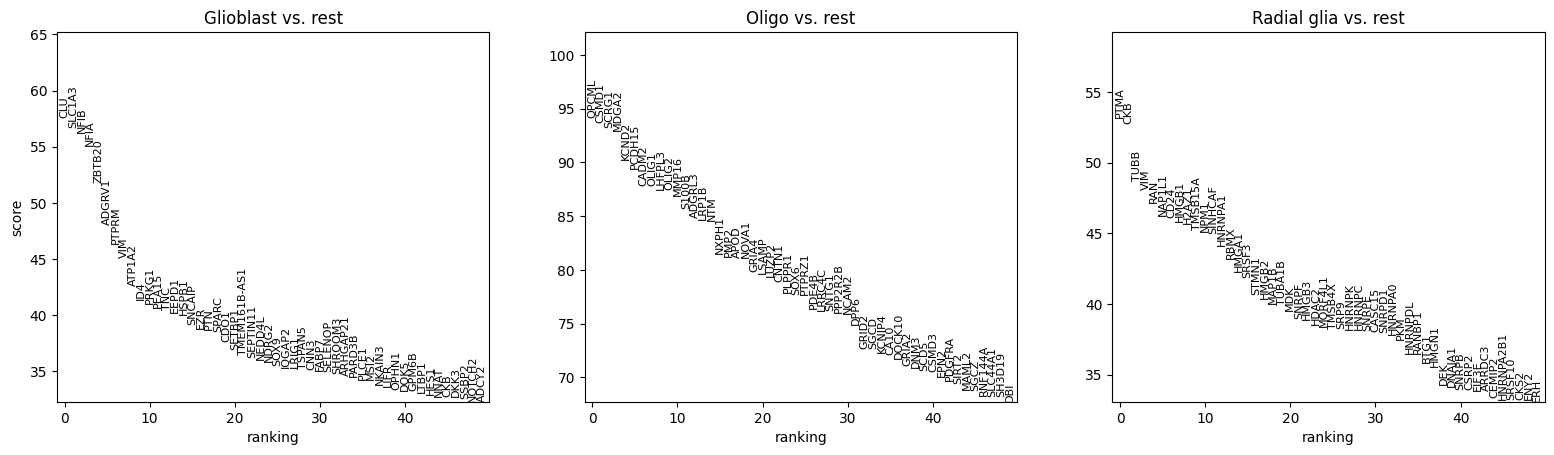

In [7]:
sc.tl.rank_genes_groups(reference, 'CellClass', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(reference, n_genes=50, sharey=False, key="wilcoxon")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


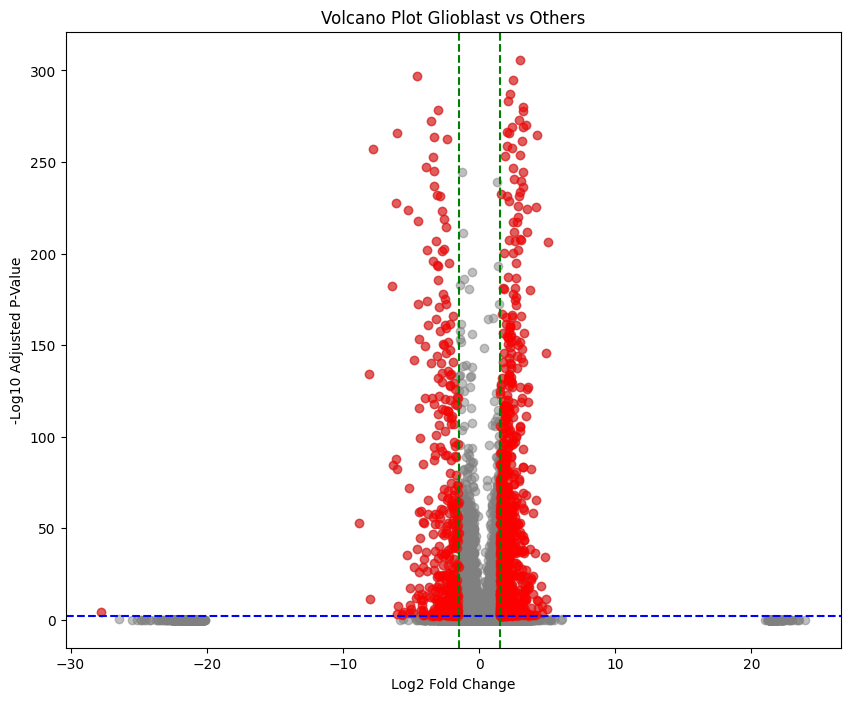

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


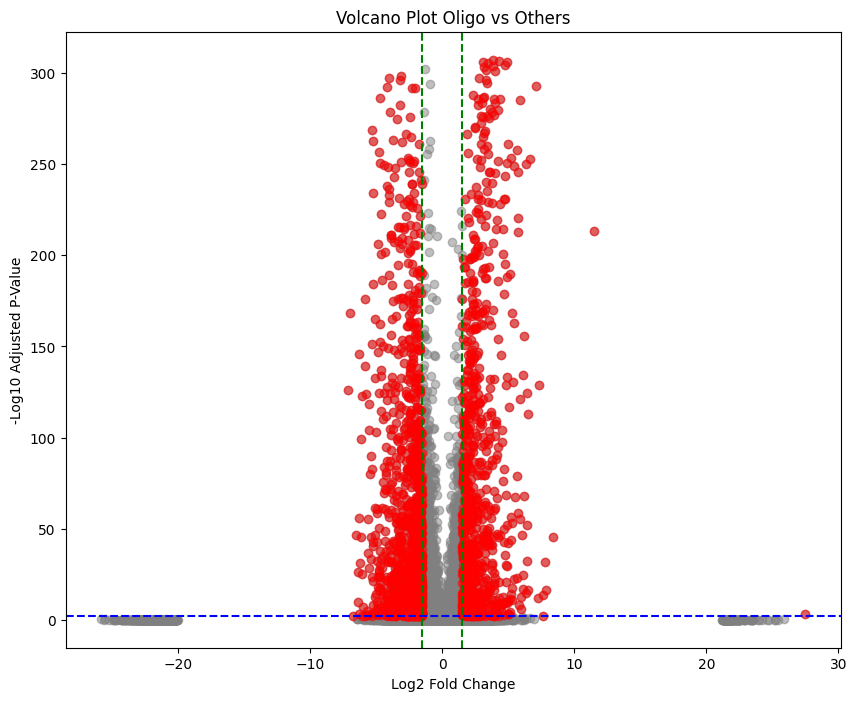

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


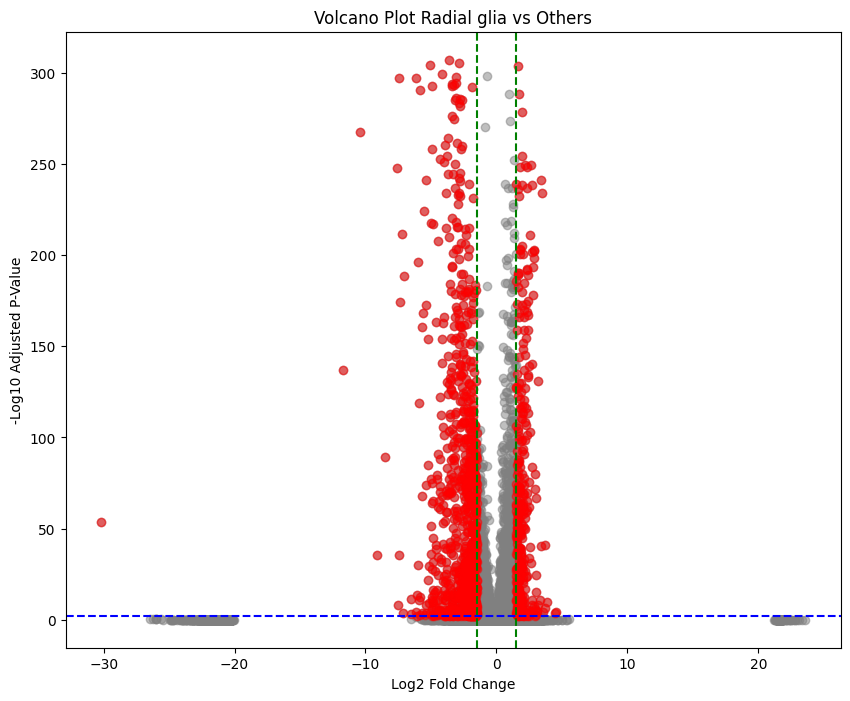

In [8]:
# Define the groups for which you want to create volcano plots
groups = reference.obs['CellClass'].unique()

# Define a threshold for significance (e.g., p-value < 0.05 and logfoldchange > 1)
significance_threshold = 0.01
fold_change_threshold = 1.5

for group in groups:
    # Extract the results for the current group
    gene_rank = sc.get.rank_genes_groups_df(reference, group=group, key='wilcoxon')[['names','logfoldchanges','pvals_adj']]
    # Calculate -log10(p-value)
    gene_rank['-log10(pvals_adj)'] = -np.log10(gene_rank['pvals_adj'])
    
    # Plot the volcano plot
    plt.figure(figsize=(10, 8))
    plt.scatter(gene_rank['logfoldchanges'], gene_rank['-log10(pvals_adj)'], c='grey', alpha=0.5)
    
    # Highlight significant points
    significant = (gene_rank['pvals_adj'] < significance_threshold) & (abs(gene_rank['logfoldchanges']) > fold_change_threshold)
    plt.scatter(gene_rank[significant]['logfoldchanges'], gene_rank[significant]['-log10(pvals_adj)'], c='red', alpha=0.5)
    
    # Add labels and lines
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10 Adjusted P-Value')
    plt.title(f'Volcano Plot {group} vs Others')
    plt.axhline(y=-np.log10(significance_threshold), color='blue', linestyle='--')
    plt.axvline(x=fold_change_threshold, color='green', linestyle='--')
    plt.axvline(x=-fold_change_threshold, color='green', linestyle='--')
    
    plt.show()


#### Enrichment Analysis

##### Over Expressed Pathways

      names     scores  logfoldchanges          pvals      pvals_adj
12      TNC  40.454803        5.452059   0.000000e+00   0.000000e+00
59   DELEC1  30.904970        5.038067  1.024258e-209  3.283124e-207
715    PI15   5.154014        4.996327   2.549693e-07   2.061075e-06
618   ADIRF   7.190922        4.894520   6.435545e-13   7.826229e-12
100    GFAP  25.945127        4.877799  2.063747e-148  3.510792e-146
Group: Glioblast, Number of genes: 856
['TNC', 'DELEC1', 'PI15', 'ADIRF', 'GFAP']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


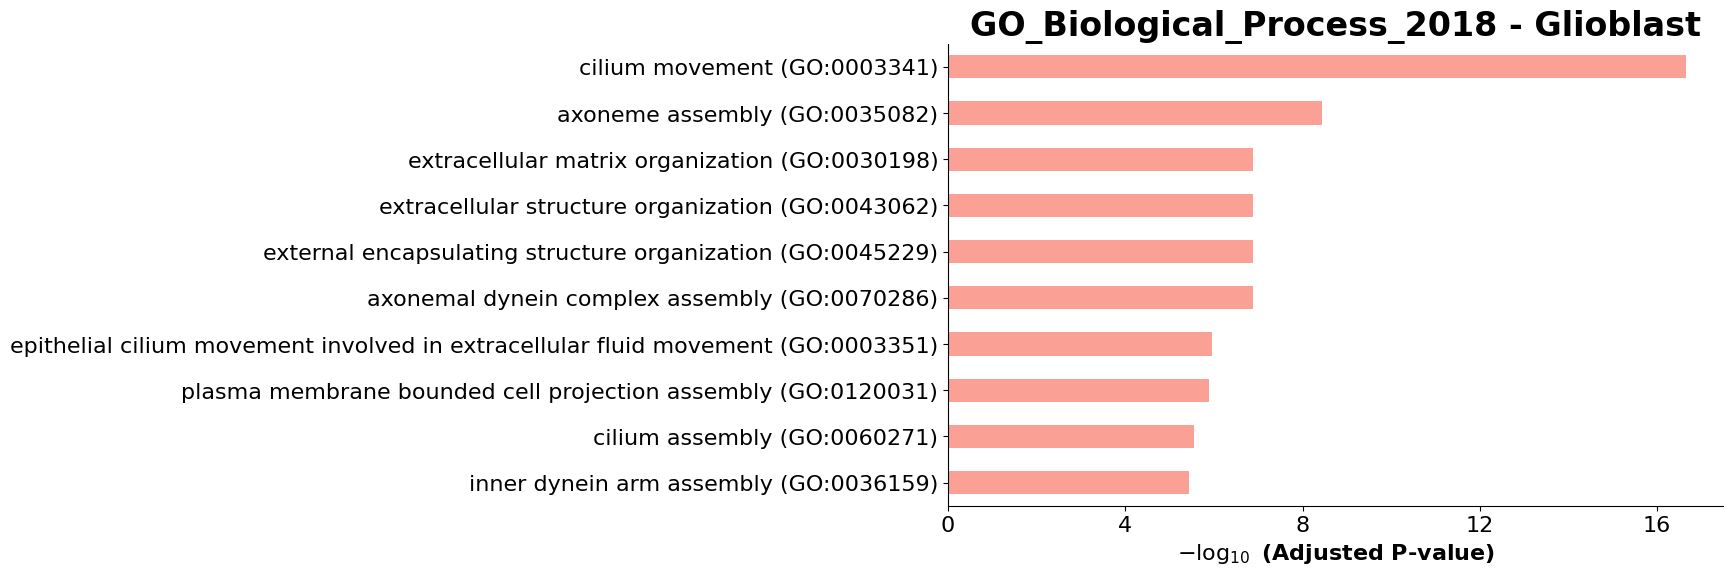

            names     scores  logfoldchanges          pvals      pvals_adj
1052  SLCO4A1-AS1   3.599820       27.498426   3.184375e-04   1.348268e-03
17           APOD  81.161461       12.399472   0.000000e+00   0.000000e+00
42         PDGFRA  69.634285       11.950889   0.000000e+00   0.000000e+00
298         KLRC3  31.372154       11.517315  4.853067e-216  3.269486e-214
113         KLRC2  50.098732       11.336436   0.000000e+00   0.000000e+00
Group: Oligo, Number of genes: 1098
['SLCO4A1-AS1', 'APOD', 'PDGFRA', 'KLRC3', 'KLRC2']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


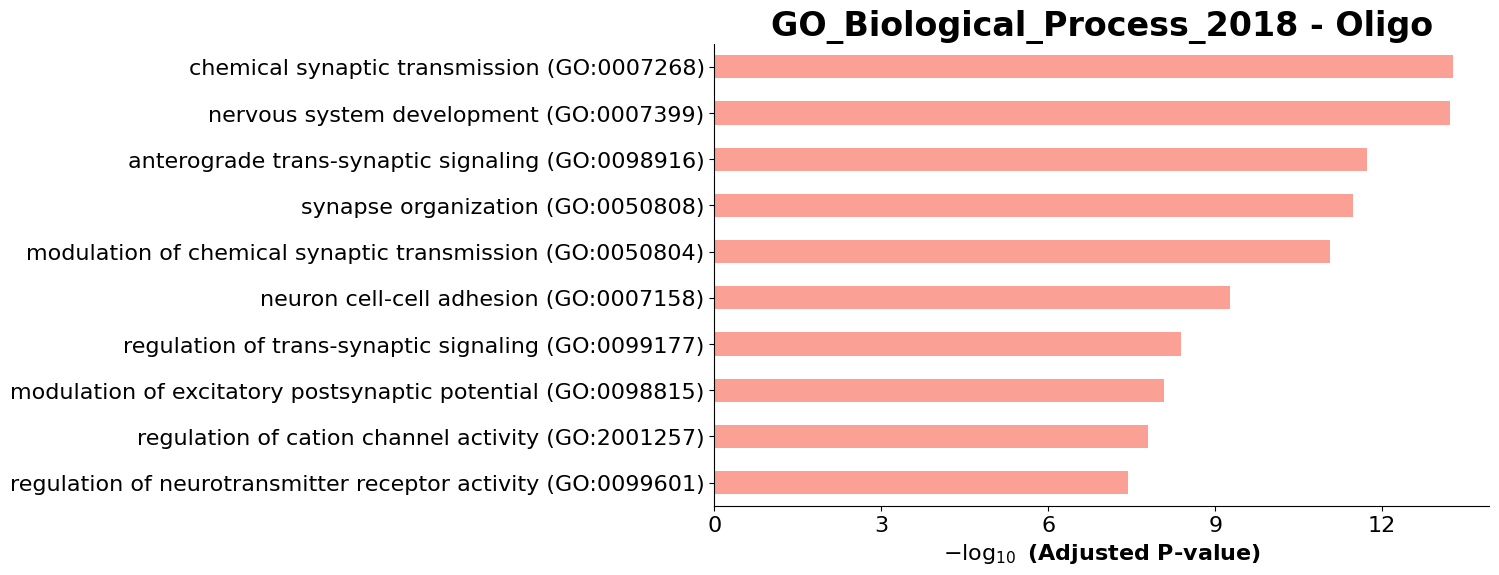

          names     scores  logfoldchanges         pvals     pvals_adj
322        AMBN   4.491143        4.554099  7.084192e-06  4.410565e-05
329  AC069133.1   4.013315        4.451148  5.987184e-05  3.373094e-04
2           VIM  48.104412        3.935416  0.000000e+00  0.000000e+00
291       SALL4   6.614138        3.840333  3.737244e-11  3.409311e-10
207       TAFA4  13.767769        3.739829  3.983258e-43  9.845308e-42
Group: Radial glia, Number of genes: 356
['AMBN', 'AC069133.1', 'VIM', 'SALL4', 'TAFA4']


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


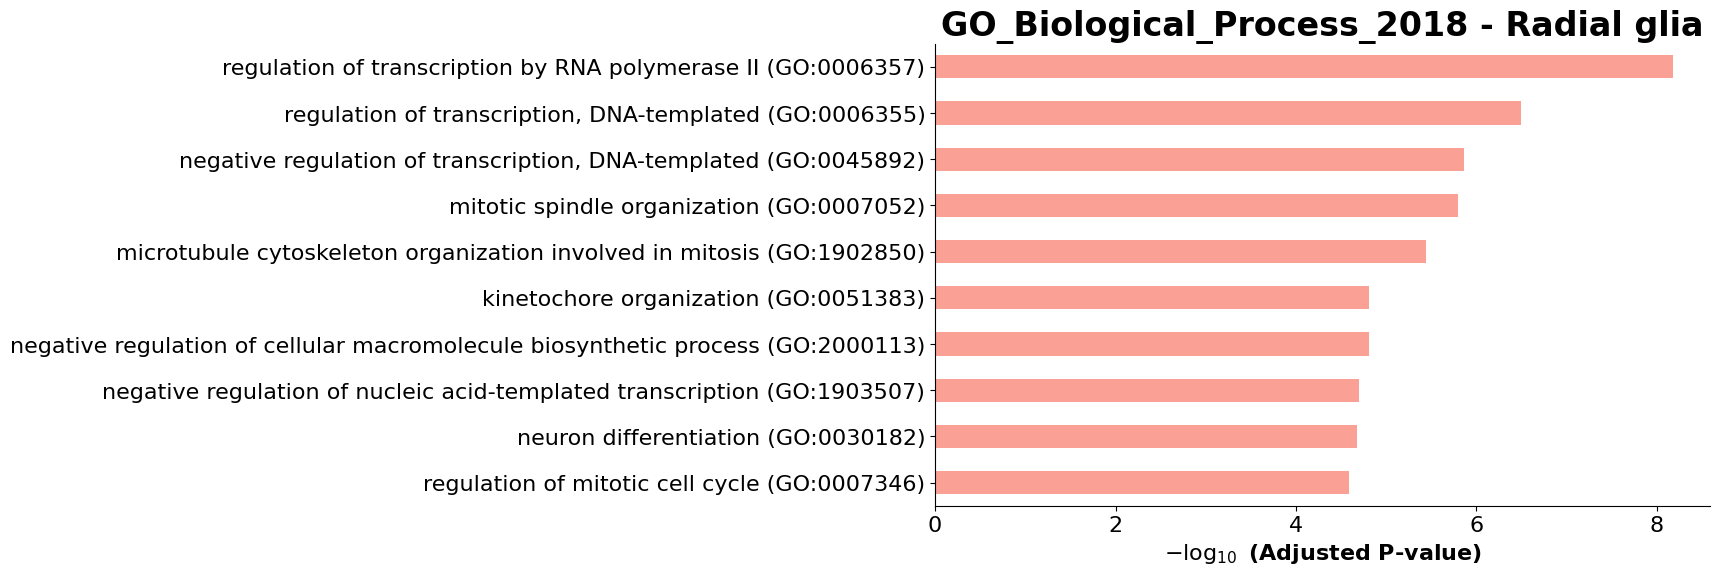

In [9]:
# Define the groups for which you want to create enrichment plots
groups = reference.obs['CellClass'].unique()

# Define a threshold for significance
log2fc_min = 1.5
pval_cutoff = 0.01

genes = []

for group in groups:
    # Extract the gene list for the current group that meets the criteria
    gene_rank = sc.get.rank_genes_groups_df(reference, group=group, key='wilcoxon', log2fc_min=log2fc_min, pval_cutoff=pval_cutoff)
    gene_rank = gene_rank.sort_values(by='logfoldchanges',ascending=False)
    gene_list = gene_rank['names'].squeeze().str.strip().tolist()
    print(gene_rank.head())
    print(f"Group: {group}, Number of genes: {len(gene_list)}")
    genes.append(gene_list)
    print(gene_list[:5])
    if len(gene_list) > 0:
        # Perform GO enrichment analysis
        enr_res = gseapy.enrichr(gene_list=gene_list, organism='Human', gene_sets='GO_Biological_Process_2021', cutoff=0.5)
        
        # Plot the enrichment results
        gseapy.barplot(enr_res.res2d, title=f'GO_Biological_Process_2018 - {group}', figsize=(10, 6))
        plt.show()

#### Under expressed pathways 

Group: Glioblast, Number of genes: 404


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


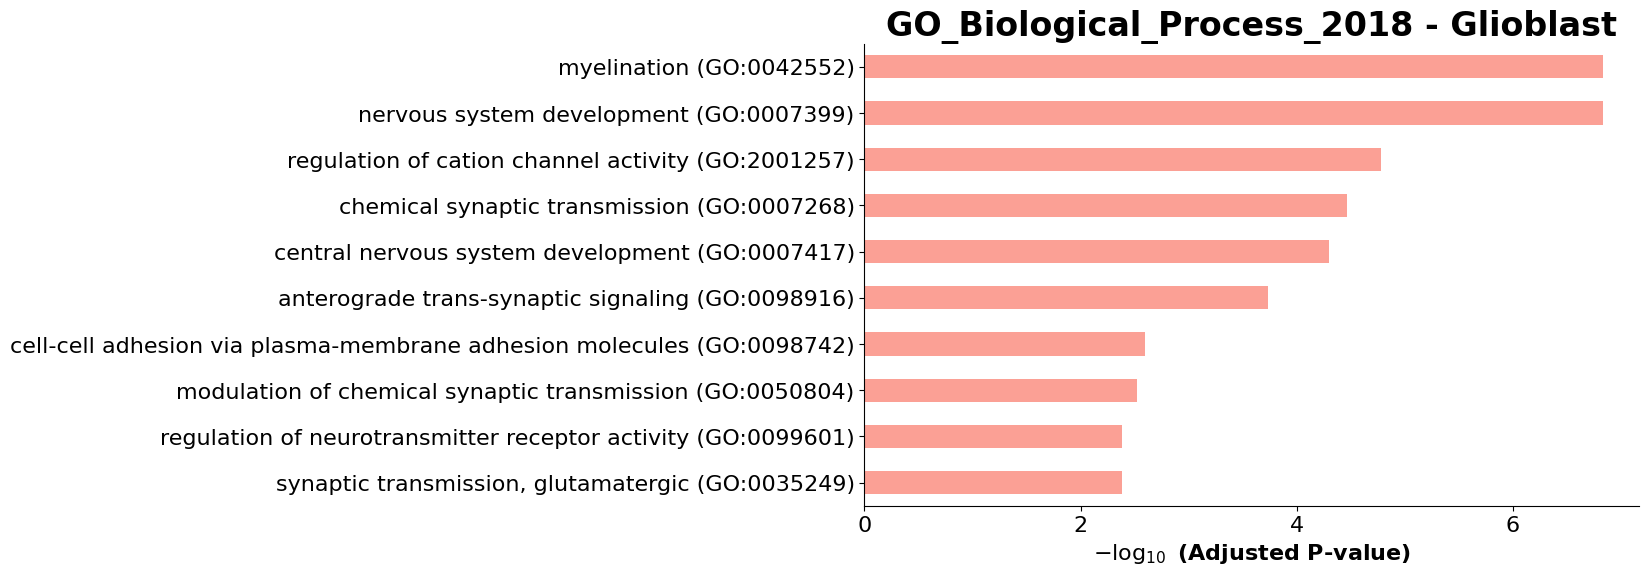

Group: Oligo, Number of genes: 1402


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


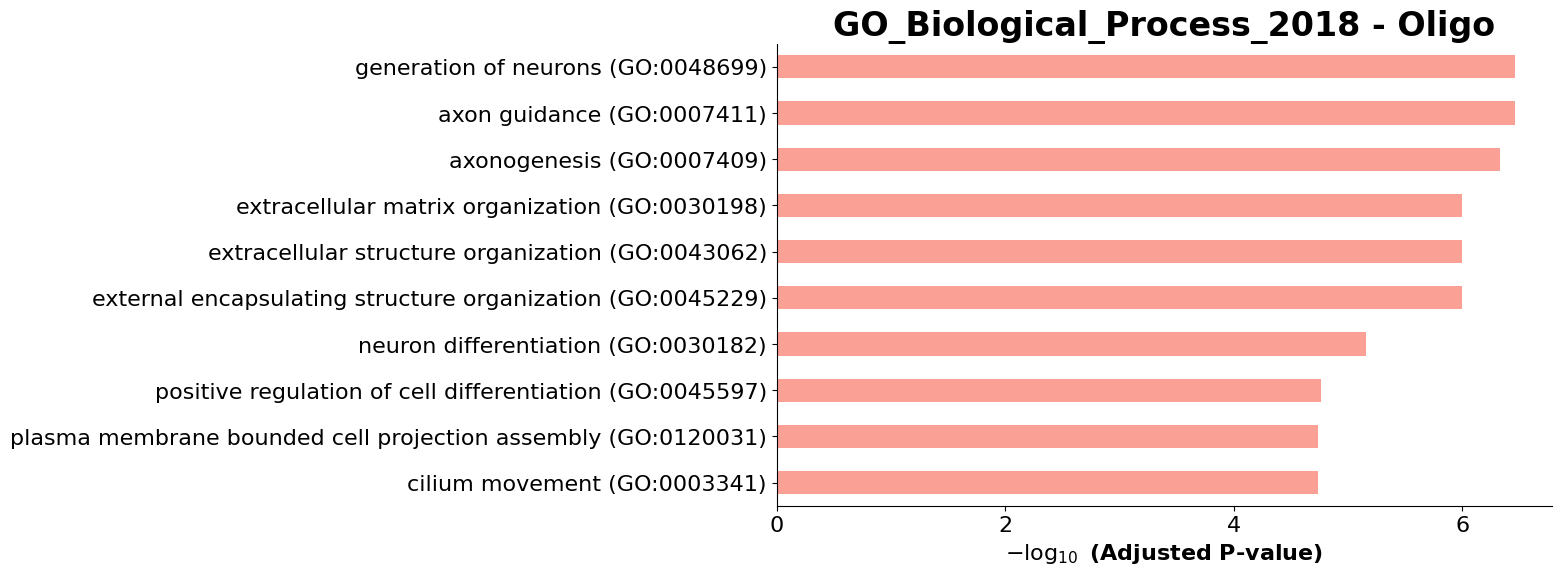

Group: Radial glia, Number of genes: 1075


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


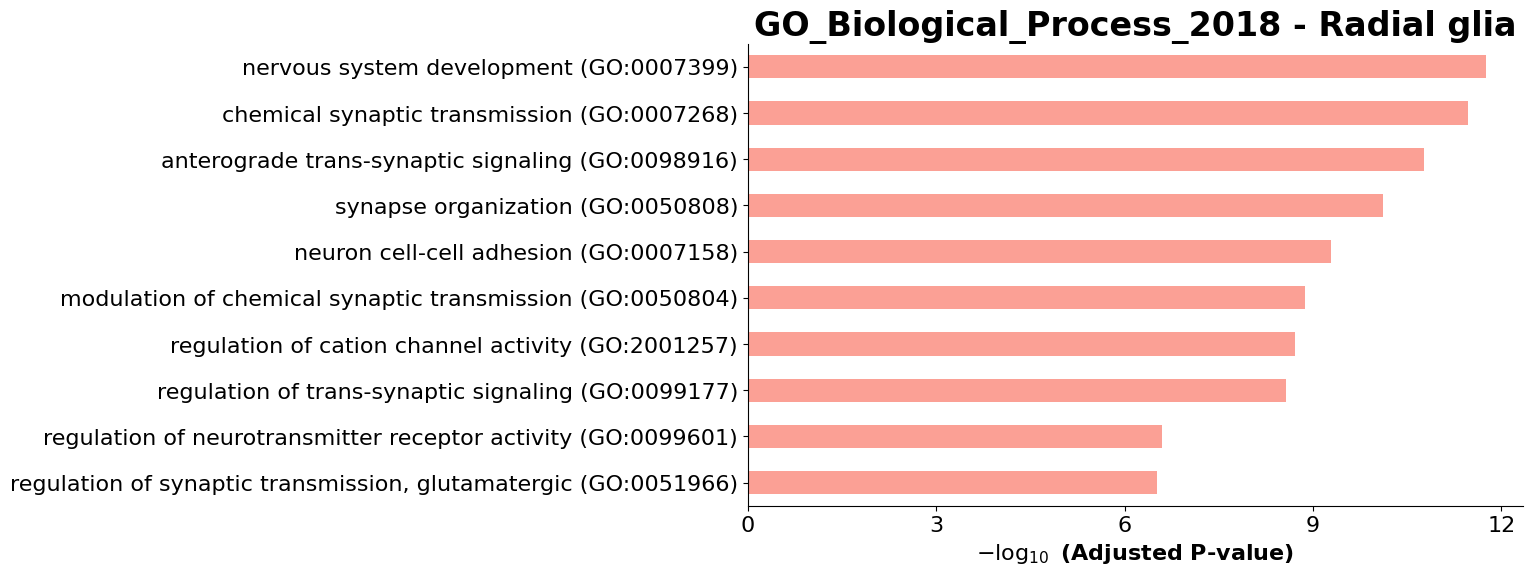

In [10]:
# Define the groups for which you want to create enrichment plots
groups = reference.obs['CellClass'].unique()

# Define a threshold for significance
log2fc_max = -1.5
pval_cutoff = 0.01

genes_under = []

for group in groups:
    # Extract the gene list for the current group that meets the criteria
    gene_rank = sc.get.rank_genes_groups_df(reference, group=group, key='wilcoxon', log2fc_max=log2fc_max, pval_cutoff=pval_cutoff)
    gene_list = gene_rank['names'].squeeze().str.strip().tolist()
    print(f"Group: {group}, Number of genes: {len(gene_list)}")
    genes_under.append(gene_list)
    if len(gene_list) > 0:
        # Perform GO enrichment analysis
        enr_res = gseapy.enrichr(gene_list=gene_list, organism='Human', gene_sets='GO_Biological_Process_2021', cutoff=0.5)
        
        # Plot the enrichment results
        gseapy.barplot(enr_res.res2d, title=f'GO_Biological_Process_2018 - {group}', figsize=(10, 6))
        plt.show()

In [11]:
# Extract the gene ranking data for the 'Radial glia' group
output_dir = "data/full_fetal_brain/dge"
os.makedirs(output_dir, exist_ok=True)

genes1 = genes[2] 
genes1_under = genes_under[2]

radial_glia = sc.get.rank_genes_groups_df(reference, group='Radial glia', key='wilcoxon')[['names', 'logfoldchanges', 'pvals_adj']]

# Filter the results to keep only the genes in `genes1`
radial_glia_filtered = radial_glia[radial_glia['names'].isin(genes1)]

# Save the filtered results to a CSV file
output_path = "data/full_fetal_brain/dge/radial_glia_DGE_up.csv"  # Replace with your desired output path
radial_glia_filtered.to_csv(output_path, index=False)


radial_glia_filtered_down = radial_glia[radial_glia['names'].isin(genes1_under)]
# Save the filtered results to a CSV file
output_path = "data/full_fetal_brain/dge/radial_glia_DGE_down.csv"  # Replace with your desired output path
radial_glia_filtered_down.to_csv(output_path, index=False)




In [12]:
# Extract the gene ranking data for the 'Radial glia' group
genes2 = genes[1]
genes2_under = genes_under[1]

oligo = sc.get.rank_genes_groups_df(reference, group='Oligo', key='wilcoxon')[['names', 'logfoldchanges', 'pvals_adj']]

# Filter the results to keep only the genes in `genes1`
oligo_filtered = oligo[oligo['names'].isin(genes2)]

# Save the filtered results to a CSV file
output_path = "data/full_fetal_brain/dge/oligo_DGE_up.csv"  # Replace with your desired output path
oligo_filtered.to_csv(output_path, index=False)

oligo_filtered_down = oligo[oligo['names'].isin(genes2_under)]
# Save the filtered results to a CSV file
output_path = "data/full_fetal_brain/dge/oligo_DGE_down.csv"  # Replace with your desired output path
oligo_filtered_down.to_csv(output_path, index=False)

In [13]:
# Extract the gene ranking data for the 'Radial glia' group
genes3 = genes[0]
genes3_under = genes_under[0]

glioblast = sc.get.rank_genes_groups_df(reference, group='Glioblast', key='wilcoxon')[['names', 'logfoldchanges', 'pvals_adj']]

# Filter the results to keep only the genes in `genes1`
glioblast_filtered = glioblast[glioblast['names'].isin(genes3)]

# Save the filtered results to a CSV file
output_path = "data/full_fetal_brain/dge/glioblast_DGE_up.csv"  # Replace with your desired output path
glioblast_filtered.to_csv(output_path, index=False)

# Filter the results to keep only the genes in `genes1`
glioblast_filtered_down = glioblast[glioblast['names'].isin(genes3_under)]

# Save the filtered results to a CSV file
output_path = "data/full_fetal_brain/dge/glioblast_DGE_down.csv"  # Replace with your desired output path
glioblast_filtered.to_csv(output_path, index=False)

In [14]:
radial_glia_top = sc.get.rank_genes_groups_df(reference, group='Radial glia', key='wilcoxon')['names'][:300]
oligo_top = sc.get.rank_genes_groups_df(reference, group='Oligo', key='wilcoxon')['names'][:300]
glio_top = sc.get.rank_genes_groups_df(reference, group='Glioblast', key='wilcoxon')['names'][:300]
genes = radial_glia_top.tolist() +  oligo_top.tolist() + glio_top.tolist() 

#sc.pl.dotplot(reference,genes, groupby='CellClass')

In [16]:
radial_glia = sc.get.rank_genes_groups_df(reference, group='Radial glia', key='wilcoxon')[['names', 'logfoldchanges', 'pvals_adj']]

# Filter the results to keep only the genes in `genes1`
radial_glia_filtered = radial_glia[radial_glia['names'].isin(radial_glia_top)]

# Save the filtered results to a CSV file
output_path = "data/full_fetal_brain/dge/radial_glia_top_300.csv"  # Replace with your desired output path
radial_glia_filtered.to_csv(output_path, index=False)

In [17]:
oligo = sc.get.rank_genes_groups_df(reference, group='Oligo', key='wilcoxon')[['names', 'logfoldchanges', 'pvals_adj']]

# Filter the results to keep only the genes in `genes1`
oligo_filtered = oligo[oligo['names'].isin(oligo_top)]

# Save the filtered results to a CSV file
output_path = "data/full_fetal_brain/dge/oligo_top_300.csv"  # Replace with your desired output path
oligo_filtered.to_csv(output_path, index=False)

In [18]:
glio = sc.get.rank_genes_groups_df(reference, group='Glioblast', key='wilcoxon')[['names', 'logfoldchanges', 'pvals_adj']]

# Filter the results to keep only the genes in `genes1`
glio_filtered = glio[glio['names'].isin(glio_top)]

# Save the filtered results to a CSV file
output_path = "data/full_fetal_brain/dge/glio_top_300.csv"  # Replace with your desired output path
glio_filtered.to_csv(output_path, index=False)